### Notebook For Exploring JPSS Fuel Moisture Content Data

To use, run in a Python 3 Kernel on  https://jupyterhub.hpc.ucar.edu/

**Installation**

In [1]:
import sys
print("Installing xarray...")
!{sys.executable} -m pip -q install "xarray[complete]"
print("xarray install complete")
print("Installing geopandas...")
!{sys.executable} -m pip -q install geopandas
print("geopandas install complete")
print("Installing sklearn...")
!{sys.executable} -m pip -q install scikit-learn
print("sklearn install complete")

Installing xarray...
xarray install complete
Installing geopandas...
geopandas install complete
Installing sklearn...
sklearn install complete


**Load Data**

In [2]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import numpy as np
import dask.distributed
print(f"xarray v. {xr.__version__}")
print(f"pandas v. {pd.__version__}")

/glade/u/home/bpetzke/.local/lib/python3.9/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


xarray v. 2022.3.0
pandas v. 1.4.2


In [3]:
client = dask.distributed.Client(processes=False,n_workers=4,threads_per_worker=4,memory_limit='auto')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bpetzke/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bpetzke/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 800.00 GiB
Status: running,Using processes: False
Comm: inproc://128.117.208.57/91424/1,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bpetzke/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 800.00 GiB
Comm: inproc://128.117.208.57/91424/7,Total threads: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/bpetzke/proxy/40261/status,Memory: 200.00 GiB
Nanny: None,


In [4]:
def load_nc_data(f_name,verbose=False):
    if verbose: print(f"Opening {f_name}")
    ts_ds = xr.open_dataset(f_name,decode_cf=True,chunks={"n_time":64,"n_site":900})
    if verbose: print("Converting Times to datetime64")
    ts_ds["Times"] = ts_ds["Times"].astype(str)
    ts_ds["Times"].data = pd.to_datetime(ts_ds["Times"].data,format="%Y-%m-%d_%H:%M:%S")
    ts_ds = ts_ds.assign_coords({"n_site":range(0,ts_ds.dims["n_site"]),"n_time":ts_ds["Times"]})
    if verbose: print("Data load complete")
    return ts_ds

In [5]:
#ts_nc = "./fmc_10h_training_conus2250m.nc"
#ts_nc = "./fmc_10h_training_conus2250m-v3.nc"
ts_nc = "./fmc_10h_training_conus375m-v7.nc"
ts_ds = load_nc_data(ts_nc,True)

Opening ./fmc_10h_training_conus375m-v7.nc


/glade/u/home/bpetzke/.local/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Converting Times to datetime64
Data load complete


In [6]:
ts_ds

<xarray.Dataset>
Dimensions:                                   (n_site: 1799, n_time: 26304)
Coordinates:
  * n_site                                    (n_site) int64 0 1 2 ... 1797 1798
  * n_time                                    (n_time) datetime64[ns] 2019-01...
Data variables: (12/69)
    latitude                                  (n_site) float32 dask.array<chunksize=(900,), meta=np.ndarray>
    longitude                                 (n_site) float32 dask.array<chunksize=(900,), meta=np.ndarray>
    Times                                     (n_time) datetime64[ns] 2019-01...
    10h_dead_fuel_moisture_content            (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    CANFRA                                    (n_site) float32 dask.array<chunksize=(900,), meta=np.ndarray>
    CLAYFRAC                                  (n_site) float32 dask.array<chunksize=(900,), meta=np.ndarray>
    ...                                        ...
    water_equiv_snow_depth                    (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    global_horizontal_irradiance              (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    sensible_heat                             (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    latent_heat                               (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    ground_heat                               (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>
    precipitable_water                        (n_time, n_site) float32 dask.array<chunksize=(64, 900), meta=np.ndarray>

**Plot 2D Variables**

In [7]:
def plot_site_var_ts(site_id, var, beg_date_str, end_date_str):
    ts_ds[var].sel(n_time=slice(beg_date_str, end_date_str),n_site=site_id).plot()

Change Site Id and Date Range Here

In [8]:
site_id = 101;
begin_date_str = "2021-07-01"
end_date_str = "2021-09-30"

In [9]:
static_vars = [
     #'Times',
     'CANFRA',
     'CLAYFRAC',
     'FRC_URB2D',
     'HGT_M',
     'slope_x',
     'slope_y',
     'IMPERV',
     'IRRIGATION',
     'LU_INDEX',
     'SANDFRAC',
     'SCB_DOM',
     'SCT_DOM',
     'SNOALB',
     'latitude',
     'longitude'
]

nwm_vars = [
    'ACCET',
    'SOILSAT_ALL',
    'soil_moisture_avail'
]

hrrr_vars = [
    'ALBEDO12M',
    'GREENFRAC',
    'LAI12M',
    'temperature_2m',
    'relative_humidity_2m',
    'wind_speed_10m',
    'skin_temperature',
    'mean_sea_level_pressure',
    'canopy_water',
    'snow_cover',
    'snow_depth',
    'dew_point_temp_2m',
    'specific_humidity_2m',
    'potential_temp_2m',
    'cloud_cover',
    'water_equiv_snow_depth',
    'global_horizontal_irradiance',
    'sensible_heat',
    'latent_heat',
    'ground_heat',
    'precipitable_water'
 ]

target = ["10h_dead_fuel_moisture_content"]

In [10]:
plot_reflectance_bands = False
reflectance_bands = []
for i in {1,2,3,4,5,7,8,10,11}:
    #reflectance_bands.append(f"750m Surface Reflectance Band M{i}")
    #reflectance_bands.append(f"750m Surface Reflectance Band M{i}_high")
    reflectance_bands.append(f"750m Surface Reflectance Band M{i}_medium")
for i in range(1,4):
    #reflectance_bands.append(f"375m Surface Reflectance Band I{i}")
    #reflectance_bands.append(f"375m Surface Reflectance Band I{i}_high")
    reflectance_bands.append(f"375m Surface Reflectance Band I{i}_medium")
    
reflectance_bands.append('LST_medium')
reflectance_bands.append('LST_medium_err')

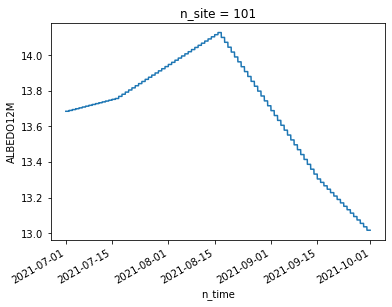

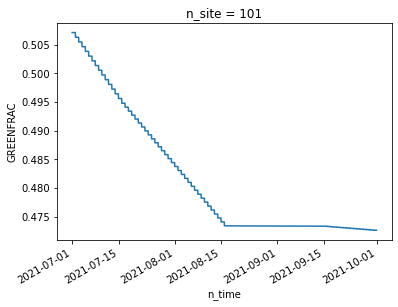

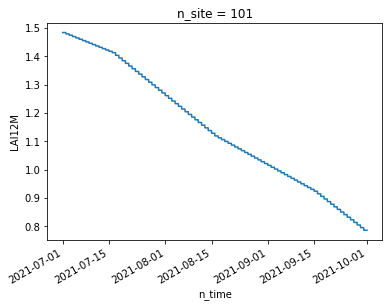

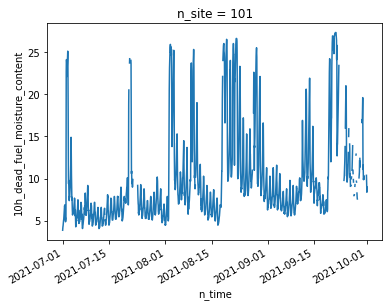

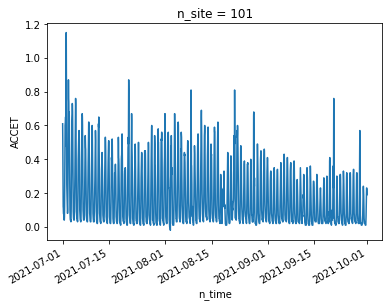

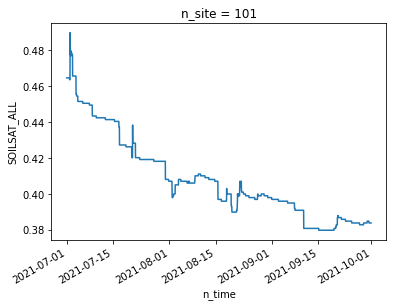

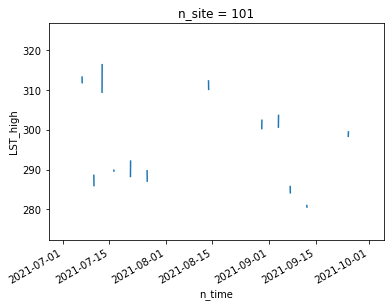

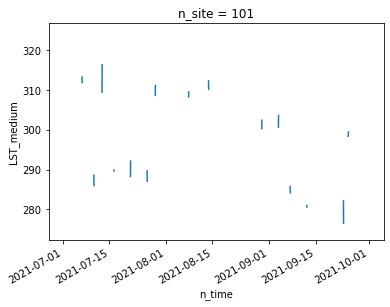

In [11]:
plot_site_var_ts(site_id,"ALBEDO12M",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"GREENFRAC",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"LAI12M",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"10h_dead_fuel_moisture_content",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"ACCET",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"SOILSAT_ALL",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"LST_high",begin_date_str, end_date_str)
plt.show()
plot_site_var_ts(site_id,"LST_medium",begin_date_str, end_date_str)
plt.show()
if plot_reflectance_bands:
    for band in reflectance_bands:
        plot_site_var_ts(site_id,band,begin_date_str, end_date_str)
        plt.show()

**Plot 1D Static Site Variables**

In [12]:
def plot_site_vars(ts_ds,var_name):
    var_da = ts_ds[var_name]
    var_df = var_da.to_dataframe().reset_index()
    state_borders = gpd.read_file('data/usa-states-census-2014.shp')
    state_borders = state_borders.to_crs("EPSG:3395")
    var_gdf = gpd.GeoDataFrame(var_df[var_name], geometry=gpd.points_from_xy(ts_ds["longitude"],ts_ds["latitude"]))
    var_gdf = var_gdf.set_crs('epsg:4326')
    var_gdf = var_gdf.to_crs(state_borders.crs)
    fig, ax = plt.subplots(figsize = (11,9))
    state_borders.boundary.plot(ax=ax,color="black")
    var_gdf.plot(column = var_name, ax=ax,cmap = 'rainbow',
                legend = True, legend_kwds={'shrink': 0.3}, 
                markersize = 10) 
    ax.set_title(var_name)


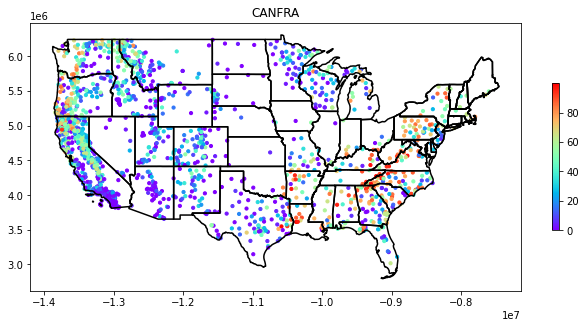

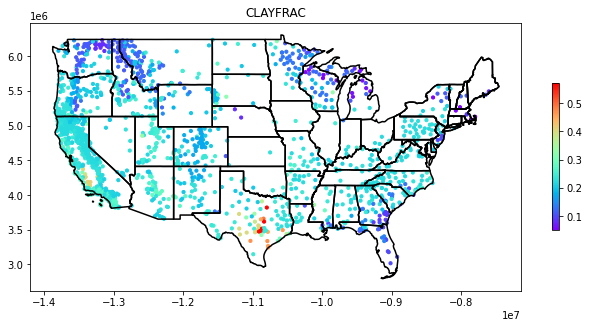

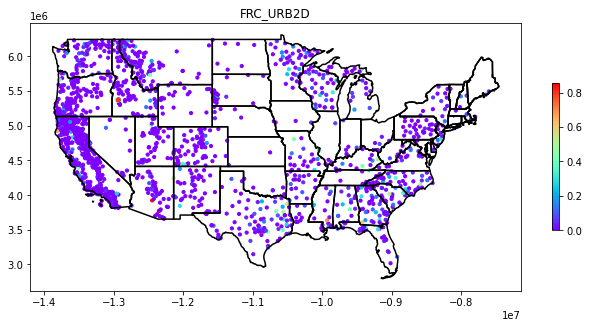

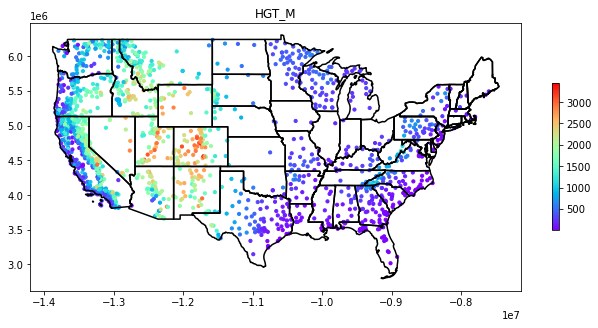

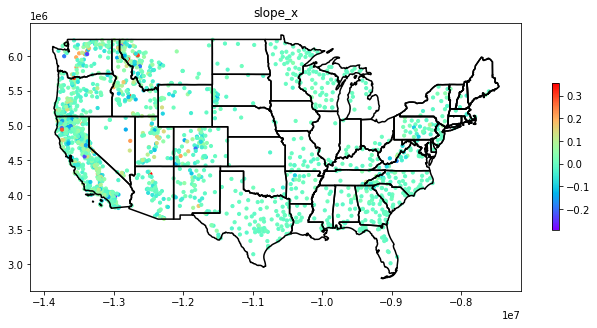

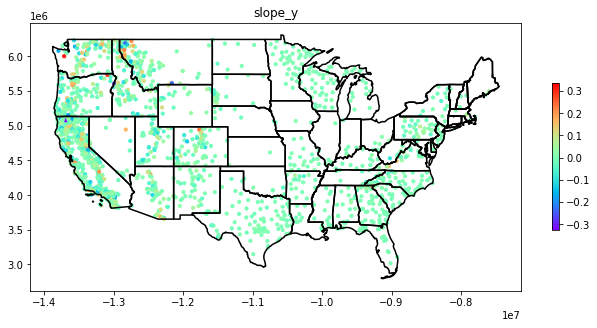

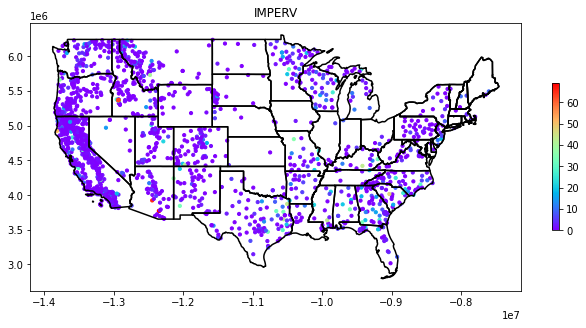

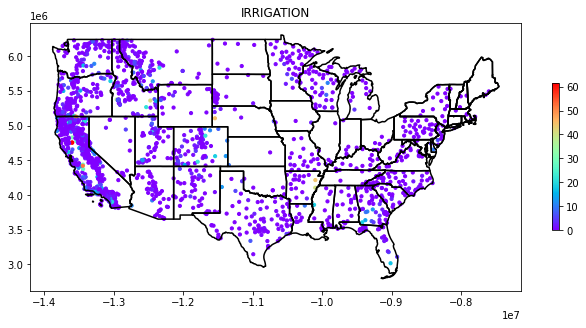

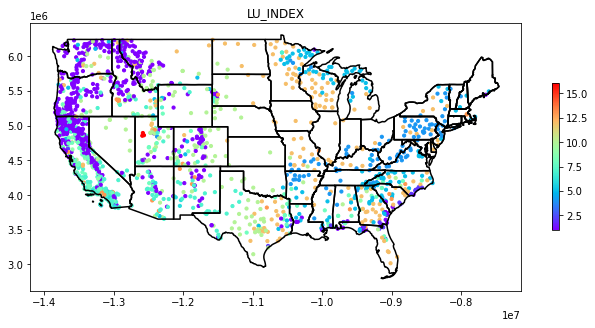

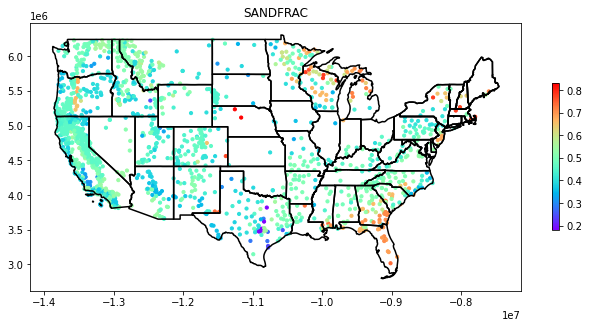

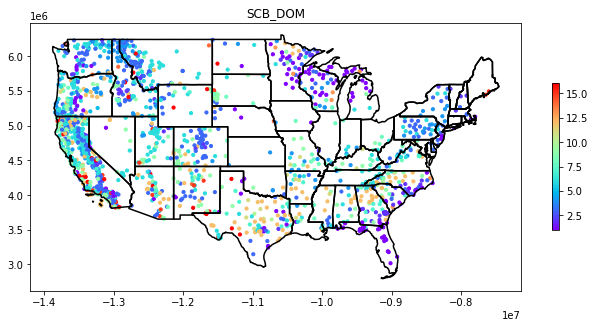

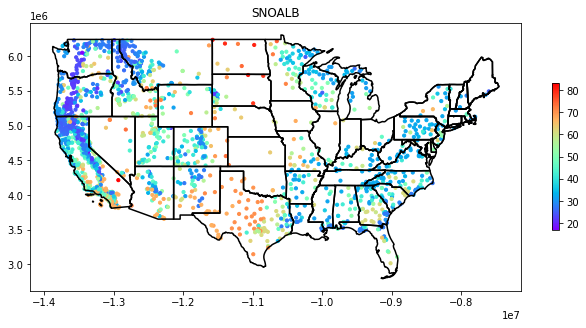

In [13]:
plot_site_vars(ts_ds,'CANFRA')
plt.show()
plot_site_vars(ts_ds,'CLAYFRAC')
plt.show()
plot_site_vars(ts_ds,'FRC_URB2D')
plt.show()
plot_site_vars(ts_ds,'HGT_M')
plt.show()
plot_site_vars(ts_ds,'slope_x')
plt.show()
plot_site_vars(ts_ds,'slope_y')
plt.show()
plot_site_vars(ts_ds,'IMPERV')
plt.show()
plot_site_vars(ts_ds,'IRRIGATION')
plt.show()
plot_site_vars(ts_ds,'LU_INDEX')
plt.show()
plot_site_vars(ts_ds,'SANDFRAC')
plt.show()
plot_site_vars(ts_ds,'SCB_DOM')
plt.show()
plot_site_vars(ts_ds,'SNOALB')
plt.show()

**Correlation Matrix**

In [14]:
def corr_matrix(ts_ds,var_list, title):
    sns.set_theme(style="white")
    ts_ds_sub = ts_ds[var_list]
    #ts_df_sub = ts_ds_sub.to_dataframe()
    ts_df_sub = ts_ds_sub.to_dask_dataframe()
    corr = ts_df_sub.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(22, 18))
    ax.set_title(title)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, cbar_kws={"shrink": .5})

In [15]:
#corr_matrix(ts_ds,target+static_vars,"Static Vars Pearson Correlation")

In [16]:
#corr_matrix(ts_ds,target+nwm_vars,"NWM Vars Pearson Correlation")

In [17]:
#corr_matrix(ts_ds,target+hrrr_vars,"HRRR Vars Pearson Correlation")

In [18]:
#corr_matrix(ts_ds,target+reflectance_bands,"Reflectance Vars Pearson Correlation")

**Random Forest Feature Importance**

In [19]:
def forest_importance(df, target, title):
    from sklearn.ensemble import RandomForestRegressor
    import matplotlib.pyplot as plt
    import joblib

    y = df.pop(target).compute()
    X = df

    #Impute Values
    #X = X.fillna(X.median())
    #Impute Values Using Dask
    X = X.fillna(X.quantile(q=0.5))
    X = X.compute()
    global client
    client.close()
    del client
    #client.cancel(df)
    X = X.drop(columns=['index'])
    #X = X.reset_index(drop=True)
    #print(X.columns)
    
    forest = RandomForestRegressor(n_jobs=-1)
    
    #client = dask.distributed.Client(processes=True,n_workers=2,threads_per_worker=4,memory_limit='120Gb')
    #print(client)
    #with joblib.parallel_backend('dask',scatter=[X, y]):
    #    forest.fit(X, y)
    forest.fit(X,y)

    feats = {}
    for feature, importance in zip(X.columns, forest.feature_importances_):
        feats[feature] = importance

    importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Random Forest Importance'})
    importances = importances.sort_values(by='Random Forest Importance',ascending=False)
    #print(importances)
    importances.plot(kind='bar',figsize=(20, 10),title=title)
    plt.show()

In [20]:
def ts_sub_features(ts_ds, var_list):
    ts_ds_sub = ts_ds[var_list]
    #ts_df_sub = ts_ds_sub.to_dataframe().reset_index()
    ts_df_sub = ts_ds_sub.to_dask_dataframe().reset_index()
    ts_df_sub = ts_df_sub.drop('n_time',1).drop('n_site',1)
    ts_df_sub = ts_df_sub.dropna()
    return ts_df_sub

def ts_all_features(ts_ds):
    #ts_ds_sub = ts_ds.to_dataframe().reset_index()
    ts_ds_sub = ts_ds.to_dask_dataframe().reset_index()
    ts_ds_sub = ts_ds_sub.drop('n_time', 1)
    ts_ds_sub = ts_ds_sub.drop('Times', 1)
    ts_ds_sub = ts_ds_sub.drop('n_site', 1)
    ts_ds_sub = ts_ds_sub.drop('LST_high_err', 1)
    ts_ds_sub = ts_ds_sub.drop('LST_medium_err', 1)
    ts_ds_sub = ts_ds_sub.dropna()
    return ts_ds_sub

In [21]:
#forest_importance(ts_all_features(ts_ds), "10h_dead_fuel_moisture_content","All Features")

In [22]:
#forest_importance(ts_sub_features(ts_ds, target+static_vars), "10h_dead_fuel_moisture_content", "Static Features")

In [23]:
#forest_importance(ts_sub_features(ts_ds, target+nwm_vars), "10h_dead_fuel_moisture_content", "NWM Features")

In [24]:
#forest_importance(ts_sub_features(ts_ds, target+hrrr_vars), "10h_dead_fuel_moisture_content", "HRRR Features")

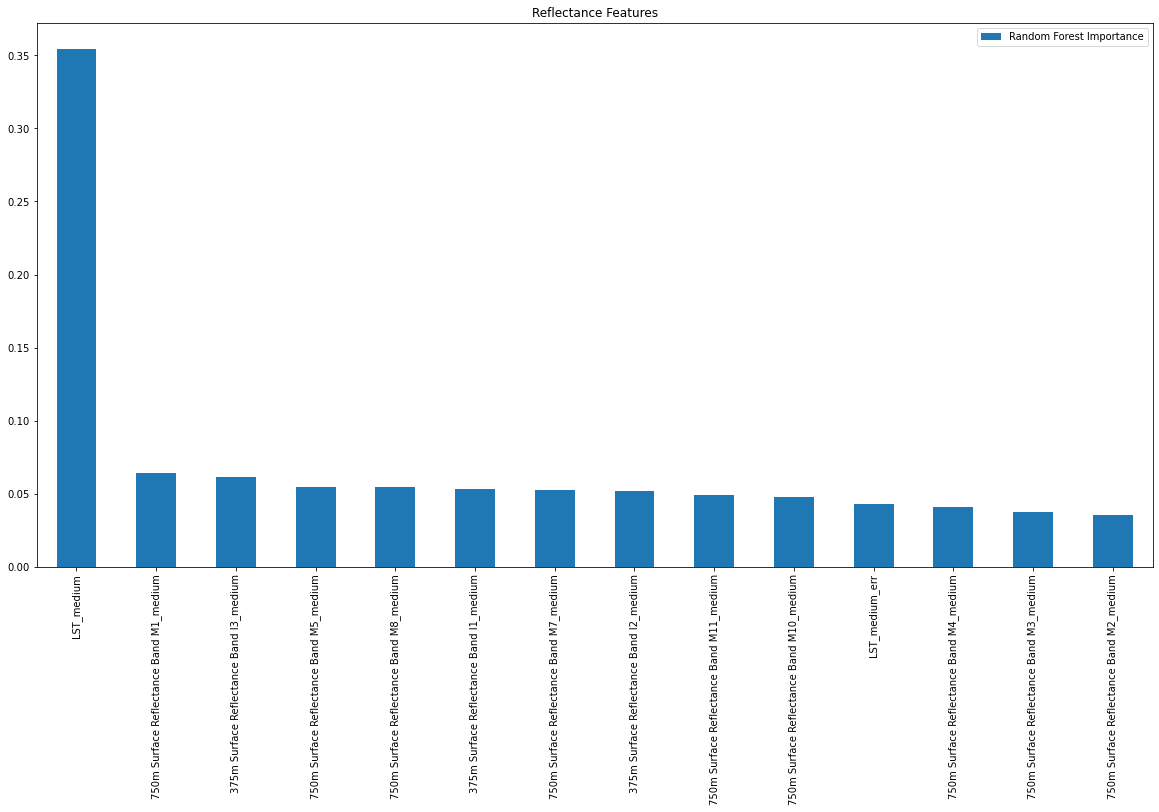

In [25]:
forest_importance(ts_sub_features(ts_ds, target+reflectance_bands), "10h_dead_fuel_moisture_content", "Reflectance Features")

In [40]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)
df_fmc = ts_ds[['10h_dead_fuel_moisture_content']].to_dataframe()
df_fmc.describe()

,10h_dead_fuel_moisture_content
count,33096582.0000
mean,13.1324
std,7.7950
min,0.0000
25%,7.6000
50%,11.6000
75%,21.0000
max,294.7390


In [42]:
a_fmc = dfm.to_numpy()
np.nanmedian(a_fmc)

11.6